In [22]:
from transformers import AutoTokenizer
import torch

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ColorJitter, ToTensor, Resize
from torchvision.models import VGG11_Weights, ResNet50_Weights
from torch.utils.data import DataLoader
from datasets import load_dataset,ClassLabel,Value,concatenate_datasets,Features,Array2D
import matplotlib.pyplot as plt
import numpy as np

In [24]:
dataset = load_dataset("fashion_mnist")

Found cached dataset fashion_mnist (/home/hakim/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
100%|██████████| 2/2 [00:00<00:00, 638.60it/s]


In [26]:
dataset["train"].select(range(50000))

Dataset({
    features: ['image', 'label'],
    num_rows: 50000
})

In [27]:
train = dataset["train"].select(range(50000))
val = dataset["train"].select(range(50000,60000))
test = dataset["test"]

In [28]:
jitter = Compose(
    [ ToTensor()]
)

In [29]:
def transforms(examples):

    examples["pixel_values"] = [jitter(image.convert("RGB")) for image in examples["image"]]

    return examples

In [30]:
train_dataset = train.with_transform(transforms)
val_dataset = val.with_transform(transforms)
test_dataset = test.with_transform(transforms)

In [31]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001

In [32]:
def collate_fn(examples):

    images = []

    labels = []

    for example in examples:

        images.append((example["pixel_values"]))

        labels.append(example["label"])

    pixel_values = torch.stack(images)

    labels = torch.tensor(labels)

    return {"pixel_values": pixel_values, "label": labels}

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size,shuffle=True,num_workers=2)
val_dataloader =  DataLoader(val_dataset, collate_fn=collate_fn, batch_size=batch_size,shuffle=True,num_workers=2)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size,shuffle=True,num_workers=2)

In [34]:
model = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [36]:
model.fc = torch.nn.Linear(2048, 10)

In [37]:
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [38]:
tr = model.train()

In [39]:
train_accu = []
train_losses = []

def train(epoch,data):
    print('\nEpoch : %d'%epoch)
    correct = 0
    running_loss=0
    total=0
    for element in data:
        # Move input and label tensors to the device
        inputs = element["pixel_values"].to(device)
        labels = element["label"].to(device)

        # Zero out the optimizer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss/len(data)
    accu=100.*correct/total

    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))


In [40]:
eval_losses=[]
eval_accu=[]

def val(data):
    correct = 0
    running_loss=0
    total=0
    with torch.no_grad():
      for element in data:
        
          inputs = element["pixel_values"].to(device)
          labels = element["label"].to(device)

        
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

    val_loss =running_loss/len(data)
    accu=100.*correct/total

    eval_accu.append(accu)
    eval_losses.append(val_loss)
    print('Val Loss: %.3f | Accuracy: %.3f'%(val_loss,accu))

In [41]:
epochs=10
for epoch in range(1,epochs+1):
  train(epoch,train_dataloader)
  val(val_dataloader)


Epoch : 1
Train Loss: 0.418 | Accuracy: 85.890
Val Loss: 0.306 | Accuracy: 89.870

Epoch : 2
Train Loss: 0.265 | Accuracy: 90.690
Val Loss: 0.267 | Accuracy: 90.140

Epoch : 3
Train Loss: 0.233 | Accuracy: 91.904
Val Loss: 0.288 | Accuracy: 90.210

Epoch : 4
Train Loss: 0.204 | Accuracy: 92.858
Val Loss: 0.241 | Accuracy: 91.390

Epoch : 5
Train Loss: 0.198 | Accuracy: 93.094
Val Loss: 0.232 | Accuracy: 92.330

Epoch : 6
Train Loss: 0.179 | Accuracy: 93.842
Val Loss: 0.259 | Accuracy: 91.280

Epoch : 7
Train Loss: 0.197 | Accuracy: 93.422
Val Loss: 0.220 | Accuracy: 92.600

Epoch : 8
Train Loss: 0.148 | Accuracy: 94.774
Val Loss: 0.259 | Accuracy: 92.110

Epoch : 9
Train Loss: 0.142 | Accuracy: 95.096
Val Loss: 0.219 | Accuracy: 92.500

Epoch : 10
Train Loss: 0.126 | Accuracy: 95.574
Val Loss: 0.245 | Accuracy: 92.230


In [42]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for element in test_dataloader:
          # Move input and label tensors to the device
        inputs = element["pixel_values"].to(device)
        labels = element["label"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 92.1 %


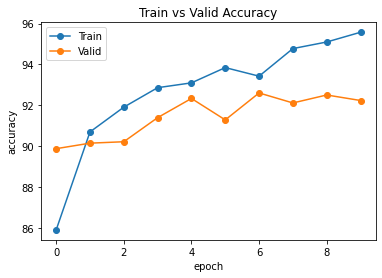

In [43]:
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

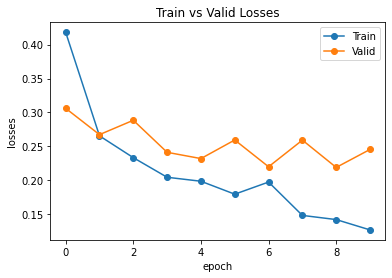

In [44]:
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [ ]:
PATH = './binary.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
from transformers import AutoTokenizer
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ColorJitter, ToTensor, Resize
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader
from tqdm import tqdm
from time import sleep
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = torchvision.models.resnet50()

In [ ]:
model.load_state_dict(torch.load("binary.pth"))

<All keys matched successfully>

In [ ]:
model = model.to(device)

In [45]:
classes = (0, 1, 2, 3 , 4, 5 ,6 ,7 ,8 ,9)

In [46]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in test_dataloader:
        inputs = data["pixel_values"].to(device)
        labels = data["label"].to(device)
        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: ',classname, "is " f'{accuracy:.1f} %')

Accuracy for class:  0 is 92.4 %
Accuracy for class:  1 is 99.2 %
Accuracy for class:  2 is 91.2 %
Accuracy for class:  3 is 93.4 %
Accuracy for class:  4 is 84.7 %
Accuracy for class:  5 is 97.0 %
Accuracy for class:  6 is 70.0 %
Accuracy for class:  7 is 96.1 %
Accuracy for class:  8 is 99.0 %
Accuracy for class:  9 is 98.0 %
